# Leitura dos dados tratados, transformação do texto em lista e separação de base entre treino e teste

In [ ]:
# Leitura dos dados
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)
df_reclamacoes = pd.read_csv('sample_data/final-dataset.csv') #O dataset utilizado já foi tratado pelo notebook SADP - Reclamações - Pré-processamento.ipynb
df_reclamacoes = df_reclamacoes.drop(labels = ["Unnamed: 0"], axis = 1)

df_reclamacoes.head()

,narrative_transformed,y_target_label
0,purchase order day shipping amount receive product week sent followup email exact verbiage paid ...,0
1,forwarded message date tue subject please investigate comenity bank retailer card scam sent hell...,0
2,forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearly w...,1
3,payment history missing credit report specialized loan servicing sl made mistake put account for...,2
4,payment history missing credit report made mistake put account forbearance without authorization...,2


In [ ]:
# Transformando coluna de narrativas em lista para vetorização
df_reclamacoes['narrative_transformed_clean'] = df_reclamacoes['narrative_transformed'].apply(lambda x: gensim.utils.simple_preprocess(x))
df_reclamacoes.head()

,narrative_transformed,y_target_label,narrative_transformed_clean
0,purchase order day shipping amount receive product week sent followup email exact verbiage paid ...,0,"[purchase, order, day, shipping, amount, receive, product, week, sent, followup, email, exact, v..."
1,forwarded message date tue subject please investigate comenity bank retailer card scam sent hell...,0,"[forwarded, message, date, tue, subject, please, investigate, comenity, bank, retailer, card, sc..."
2,forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearly w...,1,"[forwarded, message, cc, sent, friday, pdt, subject, final, legal, payment, well, fargo, well, f..."
3,payment history missing credit report specialized loan servicing sl made mistake put account for...,2,"[payment, history, missing, credit, report, specialized, loan, servicing, sl, made, mistake, put..."
4,payment history missing credit report made mistake put account forbearance without authorization...,2,"[payment, history, missing, credit, report, made, mistake, put, account, forbearance, without, a..."


In [ ]:
#balanceamento, duplicando quantidade de registros de debt_collection

df_reclamacoes_4 = df_reclamacoes[df_reclamacoes.y_target_label == 4]
print(len(df_reclamacoes))
df_reclamacoes = df_reclamacoes.append(df_reclamacoes_4,ignore_index=True)
print(len(df_reclamacoes))

162411
185559


<ipython-input-6-03666bc7a251>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reclamacoes = df_reclamacoes.append(df_reclamacoes_4,ignore_index=True)


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (df_reclamacoes['narrative_transformed_clean'], df_reclamacoes['y_target_label'] , test_size=0.2,stratify=df_reclamacoes['y_target_label'])

# Treinamento do modelo Word2vec e transformação do texto em um vetor de sentenças

In [ ]:
# Treinamento Word2vec
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=150,
                                   window=5,
                                   min_count=2)

In [ ]:
#Exibe palavras mais similares de acordo com o Vetor
w2v_model.wv.most_similar('card')

[('mastercard', 0.689340353012085),
 ('visa', 0.6571588516235352),
 ('amazon', 0.5959095358848572),
 ('walmart', 0.590581476688385),
 ('costco', 0.5754910111427307),
 ('uber', 0.569042444229126),
 ('reward', 0.5553693175315857),
 ('activated', 0.5406450033187866),
 ('platinum', 0.5360962152481079),
 ('prepaid', 0.5169888734817505)]

In [ ]:
#Transformando lista de palavras das sentenças em um vetor de sentenças para treino e teste
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

<ipython-input-10-b39a53f1e9b2>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-10-b39a53f1e9b2>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [ ]:
# Padronizando o vetor para tamanho 100 em todas posições usando a média, para não gerar erro durante a execução do treinamento do modelo
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(150, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(150, dtype=float))

# Usando KNN para realizar a classificação

In [ ]:
# Criar o classificador kNN com k = 5
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# Treinar o modelo com os dados de treinamento
knn.fit(X_train_vect_avg, y_train.values.ravel())

KNeighborsClassifier()

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test_vect_avg)

In [ ]:
#Calculando métricas do modelo
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.819 / Recall: 0.803 / Accuracy: 0.855


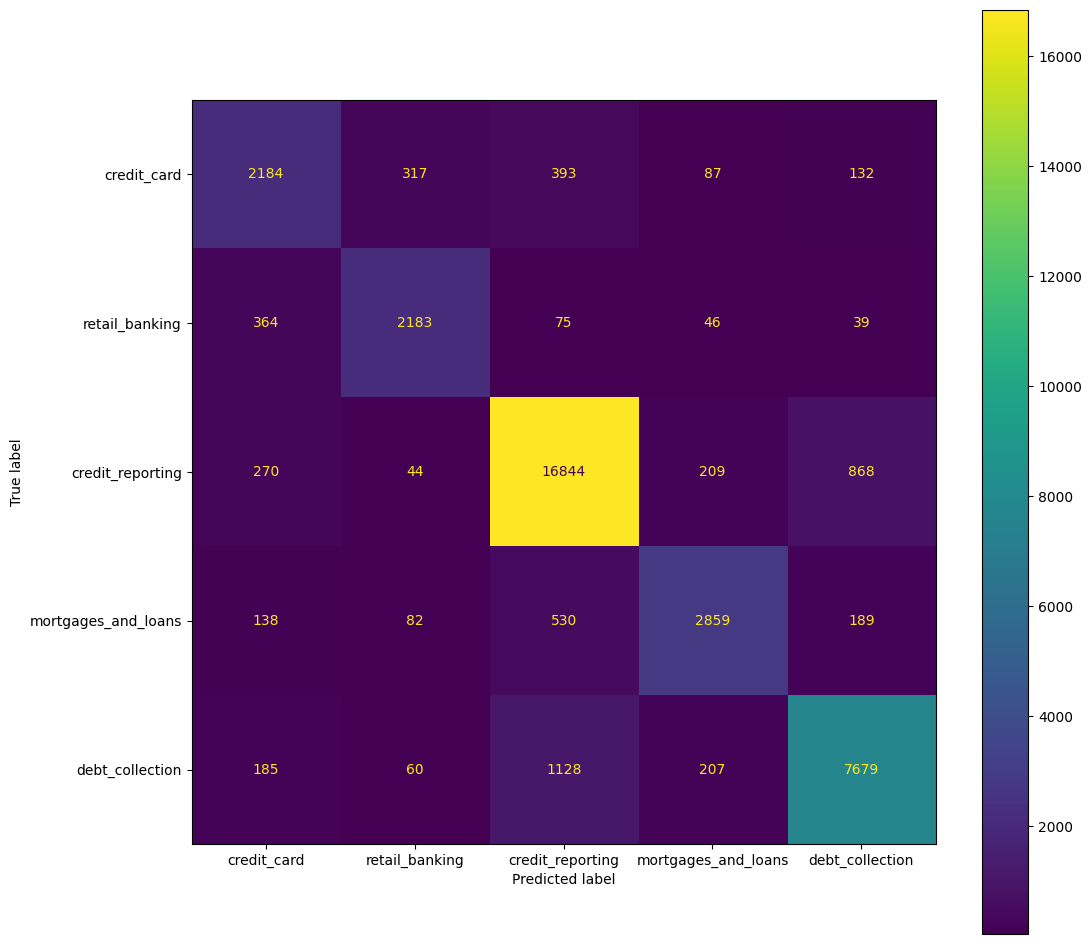

In [ ]:
#Gerando matriz de confusão
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['credit_card','retail_banking','credit_reporting','mortgages_and_loans','debt_collection'])
fig, ax = plt.subplots(figsize=(12,12))
cm_display.plot(ax=ax)


# Usando Random Forest para realizar a classificação

In [ ]:
# Instanciando e treinando com Ramdom Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [ ]:
# Realizando predição
y_pred = rf_model.predict(X_test_vect_avg)

In [ ]:
#Calculando métricas do modelo
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.866 / Recall: 0.841 / Accuracy: 0.903


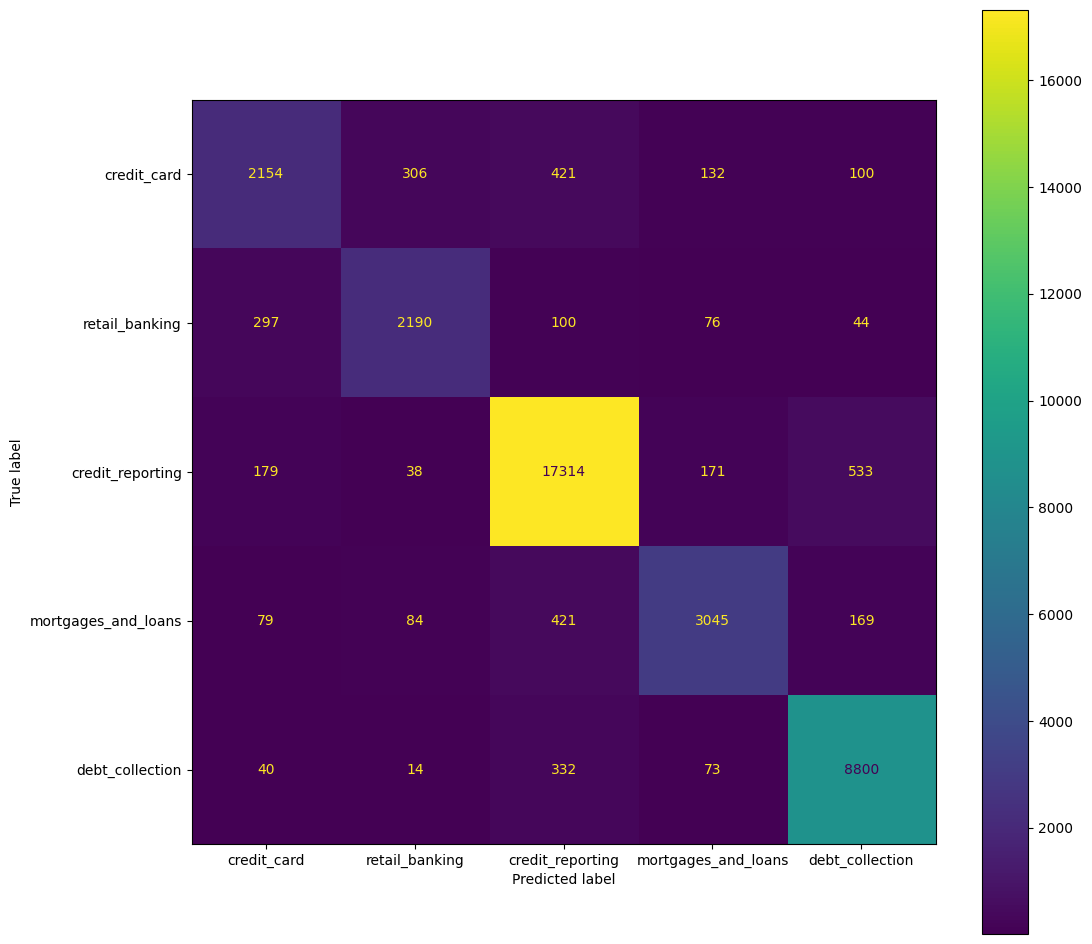

In [ ]:
#Plotando matriz de confusão
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['credit_card','retail_banking','credit_reporting','mortgages_and_loans','debt_collection'])
fig, ax = plt.subplots(figsize=(12,12))
cm_display.plot(ax=ax)
